### Linear Discrimination Analysis - Malwai

In [1]:
%matplotlib inline

import os
import sys
import json

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython.display import display
import seaborn as sns
sns.set()

# Use for 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import metrics

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))
from models import evaluation
from data.load_data import (get_country_filepaths, 
                            split_features_labels_weights)

# Constants for Functions
ALGORITHM_NAME = 'lr'
COUNTRY = 'mwi'

# Add our local functions to the path
sys.path.append(os.path.join(os.pardir, 'src'))

ALGORITHM_NAME = 'lda'
COUNTRY = 'mwi'
TRAIN_PATH, TEST_PATH, QUESTIONS_PATH = get_country_filepaths(COUNTRY)

# load text of survey questions for reference
with open(QUESTIONS_PATH, 'r') as fp:
    questions = json.load(fp)

Using TensorFlow backend.
C:\Users\micha\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\micha\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\micha\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\micha\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
# Definition of Main Variables to Predict Poverty from the Household Survey

MWI_BASIC_FEATURES = [
    'der_nchild10under', 
    'der_nmalesover10', 
    'der_nfemalesover10',
    'der_nliterate', 
    'der_nemployedpastyear',
    'hld_electricity__Yes',
    'hld_toilet__None',
    'cons_0504__Yes',
    'cons_0508__Yes'
]

In [3]:
# Standardise Data
def standardize(df, numeric_only=True):
    if numeric_only is True:
    # find non-boolean columns
        cols = df.loc[:,df.dtypes != 'uint8'].columns
    else:
        cols = df.columns
    for field in cols:
        mean, std = df[field].mean(), df[field].std()
        # account for constant columns
        if np.all(df[field]-mean != 0):
            df.loc[:,field] = (df[field]-mean)/std
    
    return df

In [4]:
def drop_duplicate_columns(df, ignore=[], inplace=False):
    if not inplace:
        df = df.copy()

    # pairwise correlations
    corr = df.corr()
    corr[corr.columns] = np.triu(corr, k=1)
    corr = corr.stack()

    # for any perfectly correlated variables, drop one of them
    for ix, r in corr[(corr == 1)].to_frame().iterrows():
        first, second = ix

        if second in df.columns and second not in ignore:
            df.drop(second, inplace=True, axis=1)

    if not inplace:
        return df

In [5]:
# Split the data for analysis
def split_features_labels_weights(df,
                                  weights=['wta_pop', 'wta_hh'],
                                  weights_col=['wta_pop'],
                                  label_col=['poor']):

    '''Split data into features, labels, and weights dataframes'''
    data = df
    return (data.drop(weights + label_col, axis=1),
            data[label_col],
            data[weights_col])

In [6]:
# Load the processed Mwai household:
mwi_hhold = pd.read_csv(r"C:\Users\micha\Documents\GitHub\mkp_code\Institute of Data Course\Project 3\data\csv_data\MWI_2010_household.csv")

In [7]:
# Split Malawi data 
mwi_train, mwi_test = train_test_split(mwi_hhold, 
                                       test_size=0.25,
                                       random_state=1443,
                                       stratify=mwi_hhold.poor)

In [8]:
# load training data
X_train, y_train, w_train = split_features_labels_weights(mwi_train)

In [9]:
# summarize loaded data
print('Data has {:,} rows and {:,} columns' \
        .format(*X_train.shape))

print('Percent poor: {:0.1%} \tPercent non-poor: {:0.1%}' \
        .format(*y_train.poor.value_counts(normalize=True, ascending=True)))

# print first 5 rows of data
X_train.head()

Data has 9,183 rows and 485 columns
Percent poor: 45.1% 	Percent non-poor: 54.9%


,hid,der_hhsize,hld_rooms,hld_nbcellpho,hld_selfscale,der_nchild10under,der_nmalesover10,der_nfemalesover10,der_nliterate,der_nemployedpastyear,...,com_medicines__Yes,com_clinic__Yes,com_distclinic__11 to 15 kilometers,com_distclinic__16 to 20 kilometers,com_distclinic__21 to 25 kilometers,com_distclinic__26 to 30 kilometers,com_distclinic__6 to 10 kilometers,com_distclinic__Above 30 kilometers,com_distclinic__nan,com_bank__Yes
7927,304044580160,5,3,0.0,1.0,3,1,1,2,0,...,0,0,0,0,0,0,0,0,0,0
4210,205205820123,3,2,1.0,3.0,1,1,1,2,1,...,1,0,0,0,0,0,0,0,0,0
457,102016880095,6,5,0.0,2.0,3,1,2,2,0,...,0,0,0,0,0,0,0,0,0,0
11951,315356330210,3,3,3.0,3.0,1,1,1,3,1,...,1,1,0,0,0,0,0,0,1,1
11428,313061660067,2,1,0.0,2.0,0,1,1,2,0,...,1,0,0,1,0,0,0,0,0,0


In [10]:
selected_columns = MWI_BASIC_FEATURES
print("X shape with selected columns:", X_train[selected_columns].shape)

X shape with selected columns: (9183, 9)


In [11]:
# Select a few columns for this example
selected_columns = [
    'der_hhsize', 
    'der_nchild10under', 
    'der_nmalesover10', 
    'der_nfemalesover10',
    'der_nliterate', 
    'der_nemployedpastyear',
    'hld_electricity__Yes',
    'hld_toilet__None',
    'cons_0504__Yes',
    'cons_0508__Yes'
]

print("X shape with selected columns:", X_train[selected_columns].shape)

X shape with selected columns: (9183, 10)


In [12]:
# Same method for getting the coefficients as we used with Malawi
def get_coefs_df(X, coefs, index=None):
    coefs_df = pd.DataFrame(np.std(X, 0)*coefs)
    coefs_df.columns = ["coef_std"]
    coefs_df['coef'] = coefs
    coefs_df['abs'] = coefs_df.coef_std.apply(abs)
    if index is not None:
        coefs_df.index = index
    return coefs_df

In [13]:
# Fit the model
model = LinearDiscriminantAnalysis()
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))



C:\Users\micha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
Wall time: 1.56 s
Wall time: 34 ms
In-sample score: 88.38%


In [14]:
# Store coefficients
coefs = get_coefs_df(X_train, model.coef_[0])


In [15]:
# load training data
X_test, y_test, w_test = split_features_labels_weights(mwi_hhold)

In [16]:
# Run the model
y_pred = model.predict(X_train)
y_prob = model.predict_proba(X_train)[:,1]

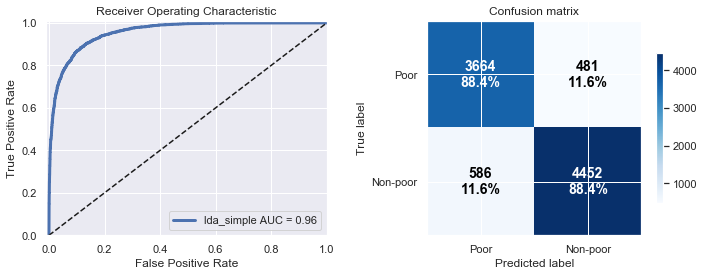

,lda_simple
accuracy,0.883807
recall,0.883957
precision,0.862118
f1,0.872901
cross_entropy,0.269238
roc_auc,0.956033
cohen_kappa,0.765921


In [17]:
# Evaluate train performance 
metrics = evaluation.evaluate_model(y_train, y_pred, y_prob, 
                                    compare_models=['lr_simple'],
                                    store_model=True,
                                    model_name='simple', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=coefs)

In [18]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9183 entries, 7927 to 7712
Columns: 485 entries, hid to com_bank__Yes
dtypes: float64(2), int64(483)
memory usage: 34.0 MB


In [19]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9183 entries, 7927 to 7712
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   poor    9183 non-null   bool 
dtypes: bool(1)
memory usage: 80.7 KB


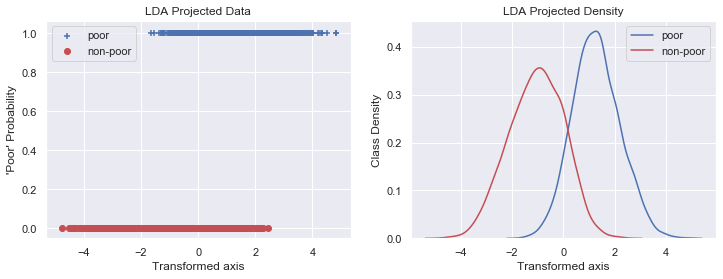

In [20]:
X_lda = model.transform(X_train)

# mask = (y_train == 1)

mask = y_train.to_numpy()

fig, axes = plt.subplots(1,2, figsize=(12,4))
axes[0].scatter(X_lda[mask], y_train[mask], color='b', marker='+', label='poor')
axes[0].scatter(X_lda[~mask], y_train[~mask], color='r', marker='o', label='non-poor')
axes[0].set_title('LDA Projected Data')
axes[0].set_xlabel('Transformed axis')
axes[0].set_ylabel('\'Poor\' Probability')
axes[0].legend()

sns.kdeplot(np.ravel(X_lda[mask]), color='b', ax=axes[1], label='poor')
sns.kdeplot(np.ravel(X_lda[~mask]), color='r', ax=axes[1], label='non-poor')
axes[1].set_title('LDA Projected Density')
axes[1].set_xlabel('Transformed axis')
axes[1].set_ylabel('Class Density')
axes[1].legend()
plt.show()

In [21]:
# Fit the model
model = LinearDiscriminantAnalysis()
%time model.fit(X_train, y_train)


C:\Users\micha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
Wall time: 1.94 s


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [22]:
from sklearn.model_selection import GridSearchCV


# build the model
estimator = LinearDiscriminantAnalysis()
parameters = {'solver': ['svd']}

model = GridSearchCV(estimator, parameters, verbose=1, cv=5)
%time model.fit(X_train, y_train)

# Get an initial score
%time score = model.score(X_train, y_train)
print("In-sample score: {:0.2%}".format(score))
coefs = get_coefs_df(X_train, model.best_estimator_.coef_[0])
print("Best model parameters:", model.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\micha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\micha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\micha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\micha\Anaconda3\lib\site-packages\sklearn\utils\validati

In [23]:
# Fit the model
model = LinearDiscriminantAnalysis()
%time model.fit(X_test, y_test)

C:\Users\micha\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
Wall time: 1.68 s


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [24]:
# Run the model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

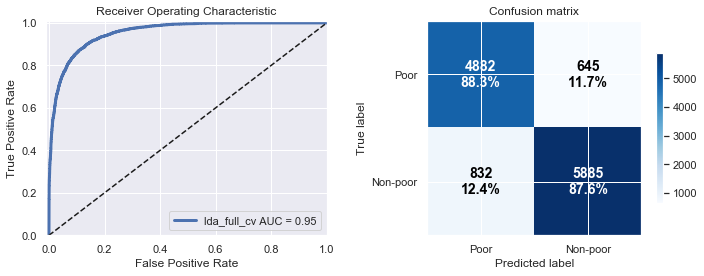

,lda_full_cv
accuracy,0.879369
recall,0.883300
precision,0.854393
f1,0.868606
cross_entropy,0.274920
roc_auc,0.954250
cohen_kappa,0.757166


In [25]:
# Evaluate test data performance 
metrics = evaluation.evaluate_model(y_test, y_pred, y_prob, 
                                    compare_models=['lr_simple'],
                                    store_model=True,
                                    model_name='full_cv', 
                                    prefix=ALGORITHM_NAME,
                                    country=COUNTRY,
                                    model=model, 
                                    features=coefs)